# Density vs Counts (2h window)

Loads `output/stability_timestep.csv` and `output/counts.csv`, computes 2-hour window averages per street aligned to each stability time step, saves a merged CSV, and plots counts vs mean density.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

stability_path = Path("../output/stability_timestep.csv")
counts_path = Path("../output/counts.csv")
output_path = Path("../output/counts_by_density.csv")

WINDOW_SECONDS = 7200  # 2 hours

In [5]:
stability = pd.read_csv(stability_path, sep=";")
counts = pd.read_csv(counts_path, sep=";")

counts = counts.sort_values("time_step").reset_index(drop=True)
street_cols = [c for c in counts.columns if c not in ("datetime", "time_step")]
print(f"Stability rows: {len(stability)}, count rows: {len(counts)}, streets: {len(street_cols)}")

Stability rows: 32, count rows: 1741, streets: 630


In [6]:
rows = []
for _, row in stability.iterrows():
    t = row["time_step"]
    mask = (counts["time_step"] > t - WINDOW_SECONDS) & (counts["time_step"] <= t)
    window_df = counts.loc[mask, street_cols]
    if window_df.empty:
        avg = pd.Series({c: pd.NA for c in street_cols})
    else:
        avg = window_df.mean()
    out_row = {"time_step": t, "mean_density_vpk": row["mean_density_vpk"]}
    out_row.update(avg.to_dict())
    rows.append(out_row)

result = pd.DataFrame(rows)
result.to_csv(output_path, index=False)
result.head()

,time_step,mean_density_vpk,649,109,651,454,455,453,635,50,...,729,726,731,730,274,266,268,269,363,362
0,7200,1.51,12.250000,0.0,3.208333,7.291667,14.875000,4.666667,24.166667,18.875000,...,27.541667,31.625000,77.541667,50.041667,9.416667,5.250000,15.666667,77.333333,30.708333,23.333333
1,14400,2.48,19.791667,0.0,3.500000,11.250000,21.875000,8.041667,35.041667,28.500000,...,41.125000,53.916667,120.250000,84.500000,14.083333,6.916667,24.833333,128.500000,47.500000,35.375000
2,24000,3.58,26.958333,0.0,5.166667,15.375000,31.291667,10.250000,45.958333,39.458333,...,59.375000,73.000000,144.083333,109.125000,17.166667,8.291667,34.666667,152.833333,63.875000,47.708333
3,39000,4.56,37.041667,0.0,8.250000,21.500000,41.208333,13.708333,57.416667,53.583333,...,80.541667,89.708333,178.625000,147.833333,23.583333,11.708333,45.625000,166.875000,85.666667,62.208333
4,47400,5.56,42.333333,0.0,10.458333,26.166667,48.166667,14.875000,64.541667,64.791667,...,92.875000,99.291667,210.125000,168.083333,29.375000,13.500000,55.583333,183.875000,92.208333,66.916667


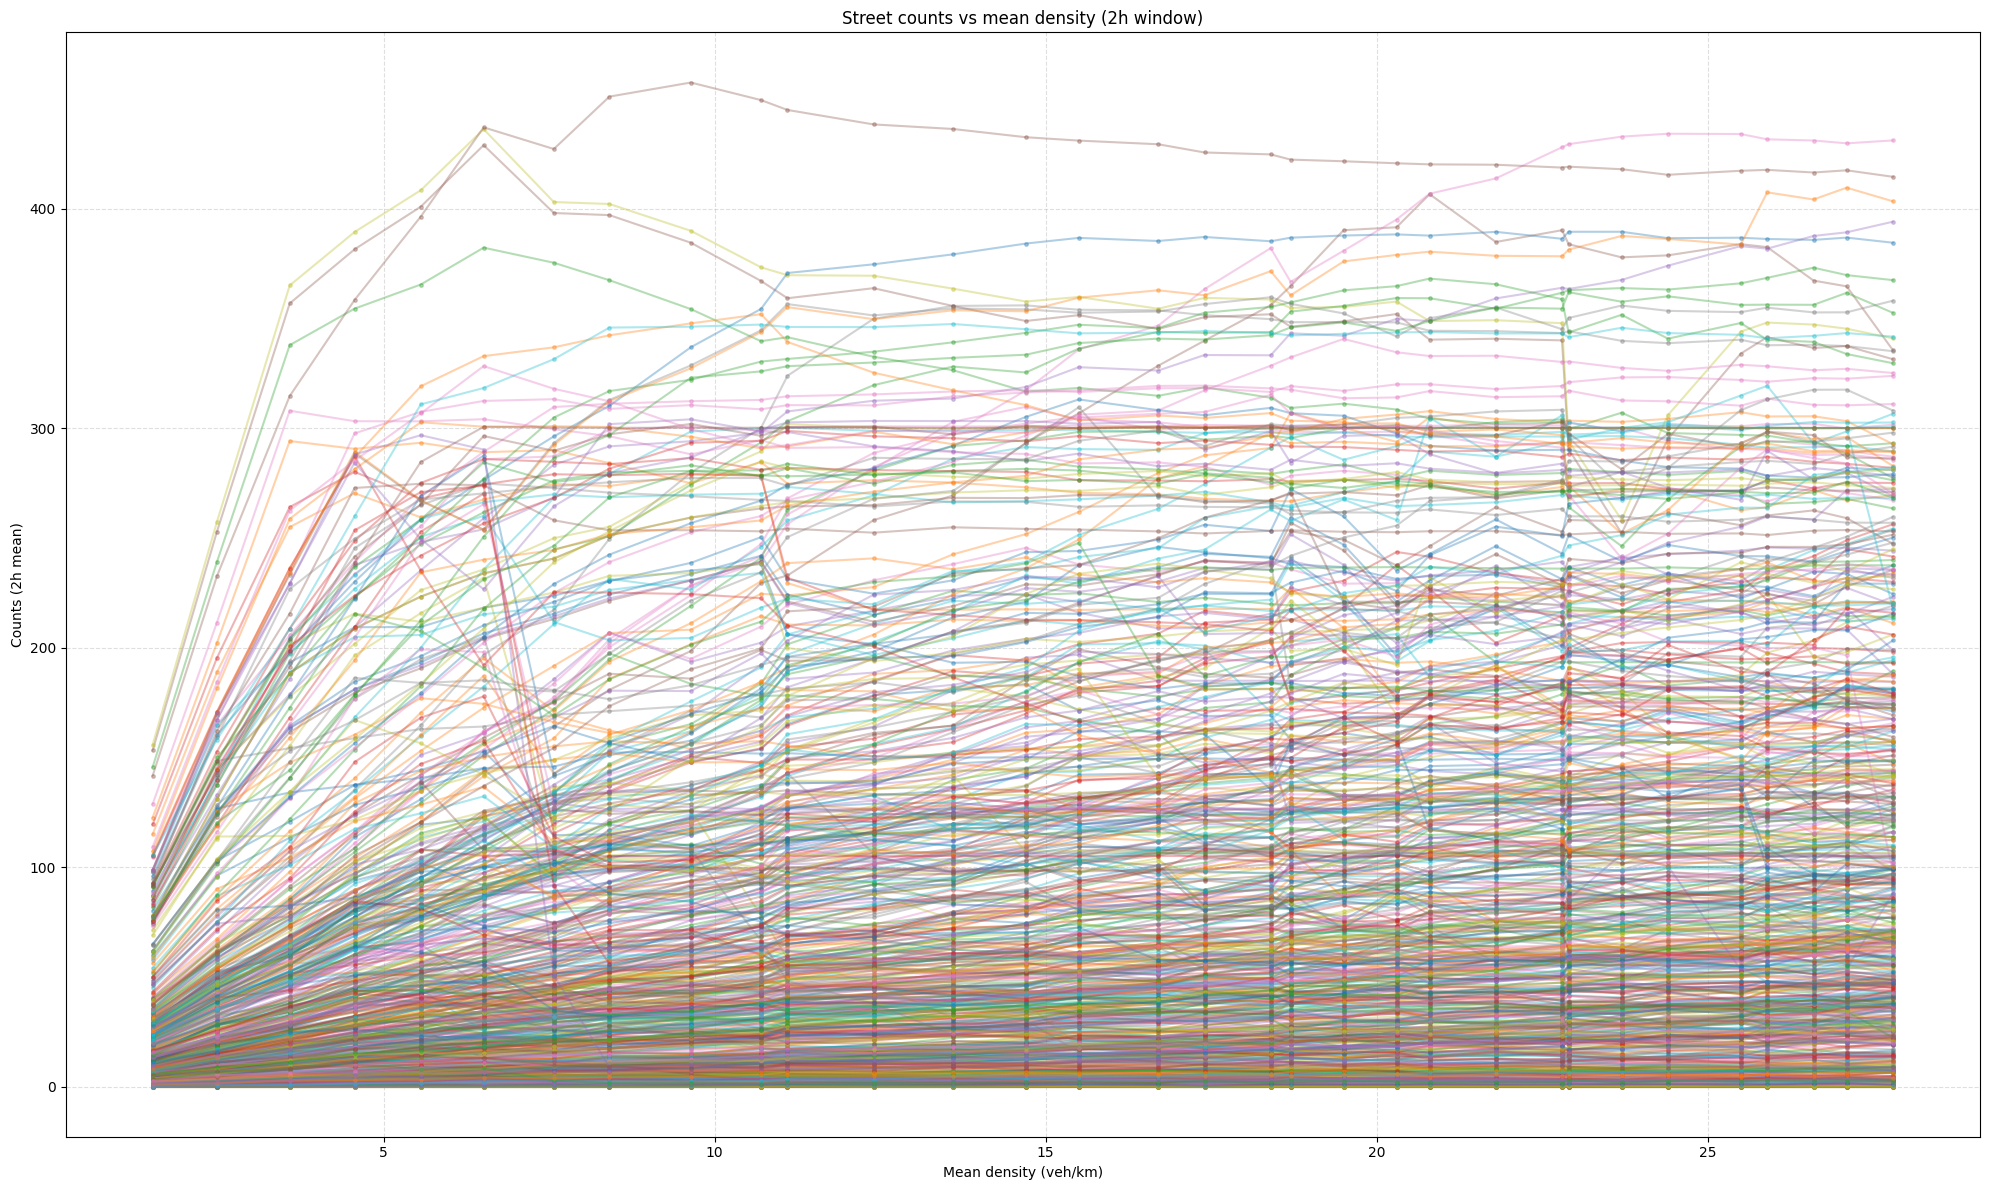

In [12]:
fig, ax = plt.subplots(figsize=(20, 12))
for col in street_cols:
    y = result[col]
    x = result["mean_density_vpk"]
    mask = y.notna() & x.notna()
    if mask.sum() < 2:
        continue
    ax.plot(x[mask], y[mask], marker="o", markersize=2.5, linewidth=1.5, alpha=0.35)

ax.set_xlabel("Mean density (veh/km)")
ax.set_ylabel("Counts (2h mean)")
ax.set_title("Street counts vs mean density (2h window)")
ax.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("../output/counts_vs_density.png", dpi=500)
plt.show()
